# Project 2: Supervised Learning
### Building a Student Intervention System

## 1. Classification vs Regression

Your goal is to identify students who might need early intervention - which type of supervised machine learning problem is this, classification or regression? Why?

## 2. Exploring the Data

Let's go ahead and read in the student dataset first.

_To execute a code cell, click inside it and press **Shift+Enter**._

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import random 

In [3]:
# Render our plots inline
%matplotlib inline

# Import the necessary modules
import matplotlib.pyplot as plt

pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (15, 5) # set the size of the output

In [4]:
# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"
# Note: The last column 'passed' is the target/label, all other are feature columns

Student data read successfully!


Now, can you find out the following facts about the dataset?
- Total number of students
- Number of students who passed
- Number of students who failed
- Graduation rate of the class (%)
- Number of features

_Use the code block below to compute these values. Instructions/steps are marked using **TODO**s._

In [5]:
student_data.count(axis=0)[0]
student_data.count(axis=1)[0]
#list(student_data.columns)
student_data[student_data['passed'] == 'yes']['passed'].count()
student_data[student_data['passed'] == 'no']['passed'].count()

130

In [6]:
# TODO: Compute desired values - replace each '?' with an appropriate expression/function call
n_students = student_data.count(axis=0)[0]
n_features = student_data.drop(['passed'], axis=1).count(axis=1)[0]
n_passed = student_data[student_data['passed'] == 'yes']['passed'].count()
n_failed = student_data[student_data['passed'] == 'no']['passed'].count()
grad_rate = (float(n_passed)/float(n_students))*100
print "Total number of students: {}".format(n_students)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Number of features: {}".format(n_features)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of students who passed: 265
Number of students who failed: 130
Number of features: 30
Graduation rate of the class: 67.09%


## 3. Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Let's first separate our data into feature and target columns, and see if any features are non-numeric.<br/>
**Note**: For this dataset, the last column (`'passed'`) is the target or label we are trying to predict.

In [7]:
# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label
print "Feature column(s):-\n{}".format(feature_cols)
print "Target column: {}".format(target_col)

X_all = student_data[feature_cols]  # feature values for all students
y_all = student_data[target_col]  # corresponding targets/labels
print "\nFeature values:-"
print X_all.head()  # print the first 5 rows

Feature column(s):-
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Target column: passed

Feature values:-
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...    

### Preprocess feature columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [8]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all_expanded = preprocess_features(X_all)
print "Processed feature columns ({}):-\n{}".format(len(X_all_expanded.columns), list(X_all_expanded.columns))

Processed feature columns (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Split data into training and test sets

So far, we have converted all _categorical_ features into numeric values. In this next step, we split the data (both features and corresponding labels) into training and test sets.

In [9]:
# First, decide how many training vs test samples you want
num_all = student_data.shape[0]  # same as len(student_data)
#num_train = int(num_all * 0.75)  # about 75% of the data
num_train = 300
num_test = num_all - num_train

from sklearn import cross_validation

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_all_expanded, y_all,
                                                                     test_size=num_test, random_state=42)

print "Total samples: {} samples".format(num_all)
print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])
# Note: If you need a validation set, extract it from within training data

Total samples: 395 samples
Training set: 300 samples
Test set: 95 samples


## 4. Training and Evaluating Models
Choose 3 supervised learning models that are available in scikit-learn, and appropriate for this problem. For each model:

- What is the theoretical O(n) time & space complexity in terms of input size?
- What are the general applications of this model? What are its strengths and weaknesses?
- Given what you know about the data so far, why did you choose this model to apply?
- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.

Produce a table showing training time, prediction time, F<sub>1</sub> score on training set and F<sub>1</sub> score on test set, for each training set size.

Note: You need to produce 3 such tables - one for each model.

In [10]:
# Train a model
import time

def train_classifier(clf, X_train, y_train):
    print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    print "Done!\nTraining time (secs): {:.3f}\n".format(end - start)

In [11]:
# Predict on training set and compute F1 score
from sklearn.metrics import f1_score

def predict_labels(clf, features, target, log_output=True):
    if log_output:
        print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    if log_output:
        print "Done!\nPrediction time (secs): {:.3f}".format(end - start)    
    return f1_score(target, y_pred, pos_label='yes')

In [22]:
# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):
    sizes = [100, 200, 300]
    
    for s in sizes:  
        X_train_b = X_train[:s]
        y_train_b = y_train[:s]
    
        print "------------------------------------------"
        print "Training set size: {}".format(len(X_train_b))
        train_classifier(clf, X_train_b, y_train_b)
        print "F1 score for training set: {}".format(predict_labels(clf, X_train_b, y_train_b))
        print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test))
        print ""

In [13]:
def get_coefficents(clf):
    column_coefs = []

    try:
        coef_ = clf.coef_[0]
    except ValueError as e:
        return None, None 
    except AttributeError as e:
        return None, None
    
    for idx in range(len(coef_)):
        col = X_all_expanded.columns[idx]
        coef = coef_[idx]
        column_coefs.append((col, coef))

    column_coefs = sorted(column_coefs, key=lambda tup: abs(tup[1]), reverse=False)

    kbest_columns = [item[0] for item in column_coefs] 
    kbest_coefs = [item[1] for item in column_coefs] 
    
    return kbest_columns, kbest_coefs

In [14]:
def plot_scores_barh(title="", feature_names=[], feature_scores=[]):
    y_pos = np.arange(len(feature_scores)) + 0.9 
    plt.barh(y_pos, feature_scores, align='center')
    plt.title(title)
    plt.xlabel("Score")
    plt.yticks(y_pos, tuple(feature_names))
    plt.show()

###Model 1: Logistic Regression 

**What is the theoretical O(n) time & space complexity in terms of input size?**
<br>Time complexity: O(n_samples)  
Space complexity: O(1) 

**What are the general applications of this model? What are its strengths and weaknesses?**
<br>General applications
- likelihood of a homeowner defaulting on a mortgage 
- Predicting the likelihood of a 'click' for ad-serving
- Predict whether a patient has a given disease based on observed characteristics
- ... 

Advantages; 
- High degree of interpretability i.e. coefficients can then be interpreted in order to understand the direction and strength of the relationships between the explanatory variables and the response variable
- Small number of params (# depedents/features + 1 i.e. grows linearly) 
- Fast to train 
- Fast in making predictions 
- Low memory requirements 
- Scales well 
- Can use a cost function to reduce over-fitting
- Allows for online training (incremental training) 
- Often used as a component in more complex algorithms (e.g. Neural networks)

Disadvantages;
- Performance not necessary good as alternatives (SVM, Random Forest, etc)
- Decision boundary must be linear 
- Disregards feature dependencies 
- Does not handle categorical data 
- Influenced by outliers 
- Affected by imbalanced training data 

**Given what you know about the data so far, why did you choose this model to apply?**<br>
Binary classification problem  

**Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.**

Training LogisticRegression...
Done!
Training time (secs): 0.004

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=42, tol=0.0001)
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.846846846847

Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.805970149254

------------------------------------------
Training set size: 100
Training LogisticRegression...
Done!
Training time (secs): 0.001

Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.859259259259
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.764705882353

------------------------------------------
Training set size: 200
Training LogisticRegression...
Done!
Training time (secs): 0.002

Predicting labels using Logi

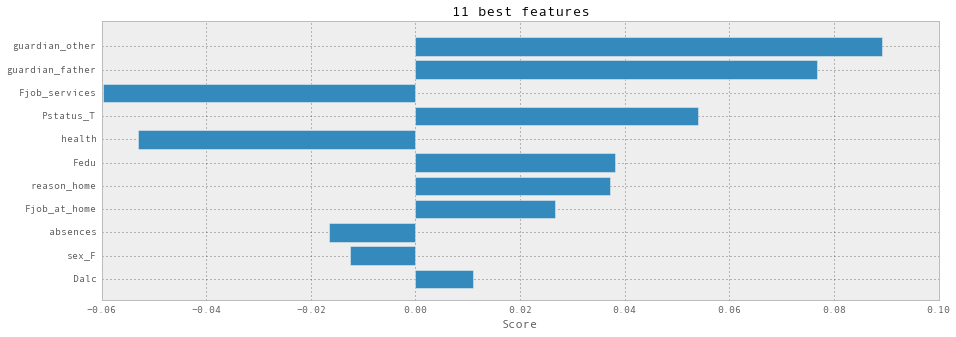

In [15]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=42)

# Fit model to training data
train_classifier(clf, X_train, y_train)  # note: using entire training set here
print clf  # you can inspect the learned model by printing it

train_f1_score = predict_labels(clf, X_train, y_train)
print "F1 score for training set: {}\n".format(train_f1_score)

# Predict on test data
print "F1 score for test set: {}\n".format(predict_labels(clf, X_test, y_test))

train_predict(clf, X_train, y_train, X_test, y_test)

kbest_columns, kbest_coefs = get_coefficents(clf)
plot_scores_barh('11 best features', kbest_columns[:11], kbest_coefs[:11])

###Model 2: SVM

**What is the theoretical O(n) time & space complexity in terms of input size?**
<br>Time complexity: O(n_samples^2 x n_features) for RBF kernel and O(n_sample x n_features) for linear SVMs
<br>Space complexity: O(1)

**What are the general applications of this model? What are its strengths and weaknesses?**
General applications 
- Text classification
- Image classification 

Advantages; 
- Works well even if your data isn’t linearly separable (with the right kernel) 
- High accuracy
- Good at handling high-dimensional spaces 

Disadvantages;
- Memory-intensive
- Hard to interpret
- Prone to overfitting noisy data
- Difficult to tune 
- Don't scale well 

**Given what you know about the data so far, why did you choose this model to apply?**<br>
The reason for choosing SVM was to take adjust of it's kernel properties in that being able to model more complex relationships. Thus used as a comparable to Logistic Regression.  

**Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.**

In [16]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf')

# Fit model to training data
train_classifier(clf, X_train, y_train)  # note: using entire training set here
#print clf  # you can inspect the learned model by printing it

train_f1_score = predict_labels(clf, X_train, y_train)
print "F1 score for training set: {}\n".format(train_f1_score)

# Predict on test data
print "F1 score for test set: {}\n".format(predict_labels(clf, X_test, y_test))

train_predict(clf, X_train, y_train, X_test, y_test)

kbest_columns, kbest_coefs = get_coefficents(clf)
if kbest_columns is not None:
    plot_scores_barh('kbest features', kbest_columns[:11], kbest_coefs[:11])

Training SVC...
Done!
Training time (secs): 0.008

Predicting labels using SVC...
Done!
Prediction time (secs): 0.005
F1 score for training set: 0.876068376068

Predicting labels using SVC...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.783783783784

------------------------------------------
Training set size: 100
Training SVC...
Done!
Training time (secs): 0.001

Predicting labels using SVC...
Done!
Prediction time (secs): 0.001
F1 score for training set: 0.877697841727
Predicting labels using SVC...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.774647887324

------------------------------------------
Training set size: 200
Training SVC...
Done!
Training time (secs): 0.002

Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
F1 score for training set: 0.867924528302
Predicting labels using SVC...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.781456953642

------------------------------------------
Training set size: 300
Tra

### Model 3: KNeighborsClassifier

**What is the theoretical O(n) time & space complexity in terms of input size?**
<br>Time complexity: O(n_samples)
<br>Space complexity: O(n_features * n_samples)

**What are the general applications of this model? What are its strengths and weaknesses?**
General applications 
- Simple classification 
- Character recognition 
- Clustering/Topic (text) classification  

Advantages; 
- Simple 
- Work well with datasets with a small number of features 
- 'Lazy' learner (online training) 
- Nonparametric decision boundaries

Disadvantages;
- Memory intense (require a lot of memory) 
- Doesn't 'learn' 
- Affected by noisy data
- Slow (distanced need to be calculated across all instances)

**Given what you know about the data so far, why did you choose this model to apply?**<br>
Despite the algorithm not meeting the functionality requirements (timely to reduce computational time) I choose KNN as a comparison/control for it's non-parametric properties (flexible decision boundaries). 

**Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.**

In [17]:
from sklearn.neighbors import KNeighborsClassifier
# weights ['uniform', 'distance']:
# we create an instance of Neighbours Classifier and fit the data.
n_neighbors = 10
clf = KNeighborsClassifier(n_neighbors, weights='distance')

# Fit model to training data
train_classifier(clf, X_train, y_train)  # note: using entire training set here
#print clf  # you can inspect the learned model by printing it

train_f1_score = predict_labels(clf, X_train, y_train)
print "F1 score for training set: {}\n".format(train_f1_score)

# Predict on test data
print "F1 score for test set: {}\n".format(predict_labels(clf, X_test, y_test))

train_predict(clf, X_train, y_train, X_test, y_test)

kbest_columns, kbest_coefs = get_coefficents(clf)
if kbest_columns is not None:
    plot_scores_barh('kbest features', kbest_columns[:11], kbest_coefs[:11])

Training KNeighborsClassifier...
Done!
Training time (secs): 0.003

Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.006
F1 score for training set: 1.0

Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.002
F1 score for test set: 0.780821917808

------------------------------------------
Training set size: 100
Training KNeighborsClassifier...
Done!
Training time (secs): 0.000

Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.001
F1 score for training set: 1.0
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.762589928058

------------------------------------------
Training set size: 200
Training KNeighborsClassifier...
Done!
Training time (secs): 0.000

Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.002
F1 score for training set: 1.0
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (s

## 5. Choosing the Best Model

- Based on the experiments you performed earlier, in 1-2 paragraphs explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?
- In 1-2 paragraphs explain to the board of supervisors in layman's terms how the final model chosen is supposed to work (for example if you chose a Decision Tree or Support Vector Machine, how does it make a prediction).
- Fine-tune the model. Use Gridsearch with at least one important parameter tuned and with at least 3 settings. Use the entire training set for this.
- What is the model's final F<sub>1</sub> score?

####(1)
I have chosen Logistic Regression as the model; This model produced the best F1 score out of the 3 models I tested, it also is the most effective (least computation cost) model addressing some of the functional and business constraints of the intended service.

Another important aspect (by product) is the model presents properties of 'good performers' and 'bad performers' such that effective intervention can take place using these are further insights. 

####(2)
Logistic Regression is one of the simplest Machine Learning algorithms and is based on the premise that the data can be split linearly by a form of function applied to the independent variables (features).

This is probably best illustrated through the use of a simple example; Imagine a dataset that has recorded student study time and whether they passed or not (i.e. binary classification). 

Here the feature is 'study time (hours)' and class is a binary output of y/1 (passed) or n/0 (failed). The job of the Logistic Regression is to model the probability of the student passing based on their ‘study time’ (at least in context of this example). 

Similar to Linear Regression, we find a line that best fits the data by deriving a constant and weights for each of the feature variables (i.e. study time) - a best fit line might look similar to the figure shown below.. 
######FIGURE IN REPORT######
 
But unlike Linear Regression, our goal is to predict the probability of a student passing given their study time. To achieve this (constrain the output between 0 and 1 aka probability) we pass the function (constant and weights/coefficients) through the logistic function, which will return a value between 0 and 1 (our probability). 
The following figure illustrates how it differs (visually) from above. 
######FIGURE IN REPORT######
 
Once the model has been trained, predictions are made by passing the feature variables through the model (using the derived constant, feature weights and logistic function) to obtain the probability, classification is then derived.

The weights are calculated using maximum likelihood estimate method, which returns the parameters that result in the minimum error between the trained predicted value and actual value (from the training dataset). 

####(3)

#####Feature Selection

Number of columns 48


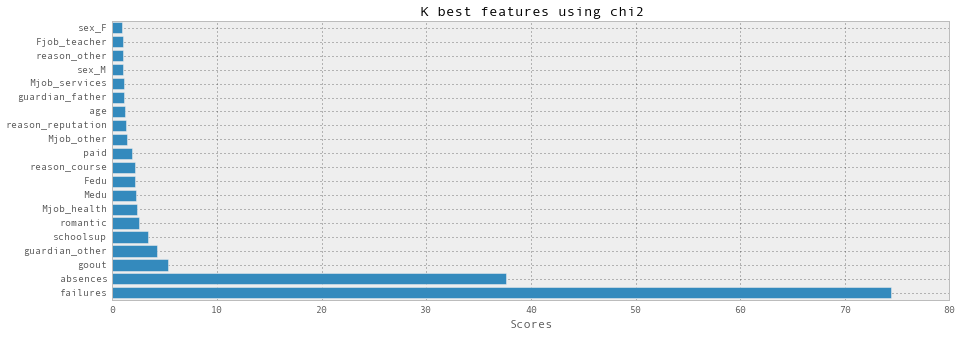

In [18]:
#from sklearn.feature_selection import SelectPercentile
#from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2

k = 20

columns = list(X_all_expanded.columns)
print("Number of columns {}".format(len(columns))) # 48

#selector = SelectPercentile(chi2, percentile=10)
selector = SelectKBest(chi2, k=k)
selector.fit(X_all_expanded, y_all)
#X_all_expanded_top = selector.transform(X_all_expanded)

column_scores = []
    
for i in range(len(selector.scores_)):
    column = columns[i] 
    score = selector.scores_[i]
    column_scores.append((column, score))
    
column_scores = sorted(column_scores, key=lambda tup: tup[1], reverse=True)[:k]

kbest_columns = [score[0] for score in column_scores] 
kbest_scores = [score[1] for score in column_scores] 

y_pos = np.arange(len(kbest_scores)) + 0.5
plt.barh(y_pos, kbest_scores, align='center')
plt.title("K best features using chi2")
plt.xlabel("Scores")
plt.yticks(y_pos, tuple(kbest_columns))
plt.show()

#####GridSearch

In [19]:
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn import grid_search

"""feature selection"""
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2

"""classifier"""
from sklearn.linear_model import LogisticRegression

f1_scorer = make_scorer(f1_score, pos_label="yes")

# 'penalty': ['l2', 'l1']
# 'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag'],

classifier_parameters = {'penalty': ['l2', 'l1'], 
                         'C':[0.001, 0.005, 0.1, 0.25, 0.5, 1.0, 1.5, 2.5, 10.0, 50.0, 100.0]}

gridsearch_clf = grid_search.GridSearchCV(LogisticRegression(random_state=42), 
                                          classifier_parameters, 
                                          scoring=f1_scorer)

gridsearch_clf.fit(X_train, y_train)
best_clf = gridsearch_clf.best_estimator_ 
print(best_clf)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l1', random_state=42, tol=0.0001)


/Users/josh/anaconda/lib/python2.7/site-packages/sklearn/metrics/metrics.py:1771: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
"""training"""
best_f1 = 0.0 
best_selector = None
best_classifier = None 

for score_func in [chi2, f_classif]:
    for k in [48, 45, 40, 35, 30, 25, 20, 15, 10, 8, 5]:
        #print("*** Iterating with SelectKBest params: score_func = {}, k={} *** ".format(score_func, k))                
        
        feature_selection_clf = SelectKBest(score_func=score_func, k=k)
        feature_selection_clf.fit(X_train, y_train)        
        
        best_X_all_expanded = feature_selection_clf.transform(X_all_expanded)        
        gridsearch_clf.fit(best_X_all_expanded, y_all)
        best_clf = gridsearch_clf.best_estimator_ 
        
        X_train_best = feature_selection_clf.transform(X_train)
        best_clf.fit(X_train_best, y_train)

        """evaluating"""        
        train_f1_score = predict_labels(best_clf, X_train_best, y_train, log_output=False)
        #print "F1 score for training set: {}".format(train_f1_score)

        # Predict on test data
        X_test_best = feature_selection_clf.transform(X_test)
        test_f1_score = predict_labels(gridsearch_clf, X_test_best, y_test, log_output=False)
        #print "F1 score for test set: {}".format(test_f1_score)
        
        if test_f1_score > best_f1:
            best_f1 = test_f1_score
            best_selector = feature_selection_clf
            best_classifier = gridsearch_clf.best_estimator_ 
            
print("***Best Classifier***")
print("Best f1 score {}".format(best_f1))
print("Best SelectKBest {}".format(best_selector))
print("Best Estimator {}".format(best_classifier))


***Best Classifier***
Best f1 score 0.805555555556
Best SelectKBest SelectKBest(k=10, score_func=<function f_classif at 0x108c2b6e0>)
Best Estimator LogisticRegression(C=0.25, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l1', random_state=42, tol=0.0001)


In [21]:
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression

selector = SelectKBest(score_func=chi2, k=10)
classifier = LogisticRegression(C=0.1, penalty='l1')

from sklearn.pipeline import Pipeline

clf = Pipeline([
        ('feature_selection', selector),
        ('classification', classifier)])

clf.fit(X_train, y_train)
test_f1_score = predict_labels(clf, X_test, y_test)
print "F1 score for test set: {}\n".format(test_f1_score)

# classifier.fit(X_train, y_train)
# test_f1_score = predict_labels(classifier, X_test, y_test)
# print "F1 score for test set: {}\n".format(test_f1_score)

Predicting labels using Pipeline...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.805555555556



---

##Alternatives 

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

def preprocess_features_b(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:            
            name = col_data.name
            col_data = le.fit_transform(col_data)
            col_data = pd.Series(col_data, name=name)

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all_encoded = preprocess_features_b(X_all)

In [ ]:
# First, decide how many training vs test samples you want
num_all = student_data.shape[0]  # same as len(student_data)
num_train = 300  # about 75% of the data
num_test = num_all - num_train

# TODO: Then, select features (X) and corresponding labels (y) for the training and test sets
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset

from sklearn import cross_validation

X_train_b, X_test_b, y_train_b, y_test_b = cross_validation.train_test_split(X_all_encoded, 
                                                                             y_all,
                                                                             test_size=num_test, 
                                                                             random_state=42)

print "Training set: {} samples".format(X_train_b.shape[0])
print "Test set: {} samples".format(X_test_b.shape[0])
# Note: If you need a validation set, extract it from within training data

### Model 4: RandomForest 

**What is the theoretical O(n) time & space complexity in terms of input size?**
<br>Time complexity: TODO
<br>Space complexity: TODO

**What are the general applications of this model? What are its strengths and weaknesses?**
General applications 
- TODO

Advantages; 
- Interpretability
- Do not expect linear features (or even features that interact linearly)
- Handle categorical data 

Disadvantages;
- Prone to over-fitting 
- Requires offline training

**Given what you know about the data so far, why did you choose this model to apply?**
TODO

**Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.**

In [ ]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=20)

# Fit model to training data
train_classifier(clf, X_train_b, y_train_b)
#print clf  # you can inspect the learned model by printing it

train_f1_score = predict_labels(clf, X_train_b, y_train_b)
print "F1 score for training set: {}\n".format(train_f1_score)

# Predict on test data
print "F1 score for test set: {}\n".format(predict_labels(clf, X_test_b, y_test_b))

train_predict(clf, X_train_b, y_train_b, X_test_b, y_test_b)

kbest_columns, kbest_coefs = get_coefficents(clf)
if kbest_columns is not None:
    plot_scores_barh('kbest features', kbest_columns[:11], kbest_coefs[:11])

### Model 4: Naive Bayes 

**What is the theoretical O(n) time & space complexity in terms of input size?**
<br>Time complexity: O(1)
<br>Space complexity: O(n_features * n_samples)

**What are the general applications of this model? What are its strengths and weaknesses?**
General applications 
- Text classification 
- Email spam filtering

Advantages; 
- Simple
- Handles non-linear data 

Disadvantages;
- ...

**Given what you know about the data so far, why did you choose this model to apply?**
TODO

**Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.**

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

# Fit model to training data
train_classifier(clf, X_train_b, y_train_b)
#print clf  # you can inspect the learned model by printing it

train_f1_score = predict_labels(clf, X_train_b, y_train_b)
print "F1 score for training set: {}\n".format(train_f1_score)

# Predict on test data
print "F1 score for test set: {}\n".format(predict_labels(clf, X_test_b, y_test_b))

train_predict(clf, X_train_b, y_train_b, X_test_b, y_test_b)